In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/eval_utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT/eval_utils')

In [3]:
import os
import numpy as np
import sklearn.metrics
import pickle
import matplotlib
import matplotlib.pyplot as plt

import _init_paths
from utils import *
from Evaluator import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes

In [4]:
#### set project name, save directory for the project
project_name = '02_Exp1_SmallGrains'
trials = ['Trial_01', 'Trial_02', 'Trial_03','Trial_04' ]
trial = trials[3] 

exp_dir = '/content/gdrive/MyDrive/exp' # experiment directory, used for reading the init model
exp_dir = os.path.join(exp_dir, project_name)
save_dir = os.path.join(exp_dir, trial) # where to save the log file and trained models.

gen_det_save_dir = '/content/gdrive/MyDrive/exp/01_Generalized_Model_FullTrainingData/Trial_03'

In [5]:
eval_dir = '/content/gdrive/MyDrive/eval' 
eval_dir = os.path.join(eval_dir, project_name, trial)

In [6]:
with open(os.path.join(gen_det_save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)    

# with open(os.path.join(save_dir,'dbinfo.plk'), 'rb') as handle:
#     dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 2389, 597)

In [7]:
gt_dir = '/content/gdrive/MyDrive/eval/01_Generalized_Model_FullTrainingData/Trial_03/gt'
sm_gt_dir = os.path.join(eval_dir, 'gt')
gen_det_dir = '/content/gdrive/MyDrive/eval/01_Generalized_Model_FullTrainingData/Trial_03/det'
sm_det_dir = os.path.join(eval_dir, 'small_grain_10a_00b_gen_val_NOTfused','det')

# define functions

In [8]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    # intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
def precision_recall_curve(y_true, pred_scores, thresholds):
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]

        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls, y_pred

In [10]:
def nms(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    bbox_list_thresholded.remove(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt

In [11]:
# modifying NMS to probabilistic fusion
def probabilistic_fusion(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    norm_fused_score_list = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)

        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    score_1=current_box[1]
                    score_2=box[1]
                    score_1_nonPollen=1-score_1
                    score_2_nonPollen=1-score_2
                    fused_score = score_1*score_2
                    fused_score_nonPollen = score_1_nonPollen*score_2_nonPollen
                    norm_fused_score = fused_score/(fused_score+fused_score_nonPollen)
                    current_box[1] = norm_fused_score
                    bbox_list_thresholded.remove(box)


                    current_box_txt = (current_box[0], str(norm_fused_score) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
                    current_box_txt = ' '.join(current_box_txt)
                    bbox_list_new_txt[-1] = current_box_txt
                    norm_fused_score_list.append(norm_fused_score)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt,norm_fused_score_list

# Loop and compile gt, det, plot P-R curve.

In [12]:
iterCount, sampleCount = 0, 0

dects = []
groundTruths = []


##### loop through #######
for idx in range(len(dbinfo['test_det_list'])):
  iterCount += 1
  current_example = dbinfo['test_det_list'][idx]

  # read gt file
  gt_filename = os.path.join(gt_dir, current_example + '.txt')
  with open(gt_filename) as file:
      for item in file:
          item = item.strip("\n")
          item = item.split(' ')
          for j in range(len(item)):
            if j > 0:
                item[j] = int(item[j])
          # gts.append(item)
          item.insert(0,current_example)
          item.insert(2,1)
          groundTruths.append(item)
          groundTruths[-1][3:] = [groundTruths[-1][3:]]


  # read gen det file
  # tmp_dects = []
  gen_det_filename = os.path.join(gen_det_dir, current_example + '.txt')
  with open(gen_det_filename) as file:
      for item in file:
          item = item.strip("\n")
          item = item.split(' ')
          item[1] = float(item[1])
          # confidence = item[1]
          # if confidence<conf_thresh:
          #     continue
          for j in range(len(item)):
            if j > 1:
                item[j] = int(item[j])
          item.insert(0,current_example)
          dects.append(item)
          # tmp_dects.append(item)
          dects[-1][3:] = [dects[-1][3:]]

  if iterCount%50==0:
    print('{}/{}'.format(iterCount,len(dbinfo['test_det_list'])))

50/597
100/597
150/597
200/597
250/597
300/597
350/597
400/597
450/597
500/597
550/597


In [13]:
IOUThreshold = 0.3

ret = []
gts = {}
npos = 0
for g in groundTruths:
    npos += 1
    gts[g[0]] = gts.get(g[0], []) + [g]

# sort detections by decreasing confidence
dects = sorted(dects, key=lambda conf: conf[2], reverse=True)
confidence = np.zeros(len(dects))
TP = np.zeros(len(dects))
FP = np.zeros(len(dects))
# create dictionary with amount of gts for each image
det = {key: np.zeros(len(gts[key])) for key in gts}

# print("Evaluating class: %s (%d detections)" % (str(c), len(dects)))
# Loop through detections
for d in range(len(dects)):
    # print('dect %s => %s' % (dects[d][0], dects[d][3],))
    # Find ground truth image
    gt = gts[dects[d][0]] if dects[d][0] in gts else []
    iouMax = sys.float_info.min
    for j in range(len(gt)):
        # print('Ground truth gt => %s' % (gt[j][3],))
        iou = IOU(dects[d][3], gt[j][3])
        if iou > iouMax:
            iouMax = iou
            jmax = j
    # Assign detection as true positive/don't care/false positive
    if iouMax >= IOUThreshold:
        if det[dects[d][0]][jmax] == 0:
            TP[d] = 1  # count as true positive
            det[dects[d][0]][jmax] = 1  # flag as already 'seen'
            confidence[d] = dects[d][2]
            # print("TP")
        else:
            FP[d] = 1  # count as false positive
            confidence[d] = dects[d][2]
            # print("FP")
    # - A detected "cat" is overlaped with a GT "cat" with IOU >= IOUThreshold.
    else:
        FP[d] = 1  # count as false positive
        confidence[d] = dects[d][2]
        # print("FP")
# compute precision, recall and average precision
acc_FP = np.cumsum(FP)
acc_TP = np.cumsum(TP)
rec = acc_TP / npos
prec = np.divide(acc_TP, (acc_FP + acc_TP))
# Depending on the method, call the right implementation
#if method == MethodAveragePrecision.EveryPointInterpolation:
[ap, mpre, mrec, ii] = Evaluator.CalculateAveragePrecision(rec, prec)
#else:
# [ap, mpre, mrec, _] = Evaluator.ElevenPointInterpolatedAP(rec, prec)
# create dictionary of result
result = {'param':'gen_det',
    'precision': prec,
    'recall': rec,
    'AP': ap,
    'interpolated precision': mpre,
    'interpolated recall': mrec,
    'total positives': npos,
    'total TP': np.sum(TP),
    'total FP': np.sum(FP),
    'confidence': confidence
}
ret.append(result)

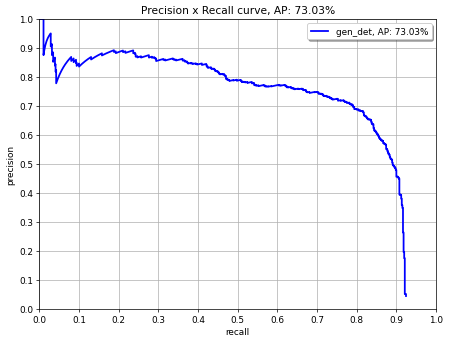

In [14]:
param = ret[0]['param']
precision = ret[0]['precision']
recall = ret[0]['recall']
average_precision = ret[0]['AP']
# mpre = result['interpolated precision']
# mrec = result['interpolated recall']
# npos = result['total positives']
# total_tp = result['total TP']
# total_fp = result['total FP']
# confidence = result['confidence']

fig = plt.figure(figsize=(8,6), dpi=64, facecolor='w', edgecolor='k')

ap_str = "{0:.2f}%".format(average_precision * 100)
plt.title('Precision x Recall curve, AP: %s' % (ap_str))


plt.xlim([0, 1])
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, step=0.1))

plt.plot(recall, precision, color='blue', linewidth=2, label='%s, AP: %s' % (param, ap_str))
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(shadow=True)
plt.grid()

In [15]:
# iterCount, sampleCount = 0, 0

# dects = []
# groundTruths = []

#### set hyperparameters ######

# conf_thresh = 0.8
# a_list = np.arange(2,6,1.0)
# b_list = np.arange(-3,4, 1.0)
# b_list = [0.0]

a_list = [5.5]
b_list = [4.9]

sampleCount = 0

for a in a_list:
  a = round(a,2)
  for b in b_list:
    b = round(b,2)
    ##### loop through #######
    iterCount = 0
    dects = []
    groundTruths = []
    for idx in range(len(dbinfo['test_det_list'])):
      iterCount += 1
      current_example = dbinfo['test_det_list'][idx]

      # read gt file
      gt_filename = os.path.join(gt_dir, current_example + '.txt')
      with open(gt_filename) as file:
          for item in file:
              item = item.strip("\n")
              item = item.split(' ')
              for j in range(len(item)):
                if j > 0:
                    item[j] = int(item[j])
              # gts.append(item)
              item.insert(0,current_example)
              item.insert(2,1)
              groundTruths.append(item)
              groundTruths[-1][3:] = [groundTruths[-1][3:]]


      # read gen det file
      tmp_dects = []
      gen_det_filename = os.path.join(gen_det_dir, current_example + '.txt')
      with open(gen_det_filename) as file:
          for item in file:
              item = item.strip("\n")
              item = item.split(' ')
              item[1] = float(item[1])
              # confidence = item[1]
              # if confidence<conf_thresh:
              #     continue
              for j in range(len(item)):
                if j > 1:
                    item[j] = int(item[j])
              tmp_dects.append(item)

      # read sm det file
      sm_det_filename = os.path.join(sm_det_dir, current_example + '.txt')
      with open(sm_det_filename) as file:
          for item in file:
              item = item.strip("\n")
              item = item.split(' ')
              item[1] = float(item[1])
              item[1] = 1/(1 + np.exp(-item[1]*a + b))
              # item[1] =item[1]*a + b       
              for j in range(len(item)):
                if j > 1:
                    item[j] = int(item[j]) 
              # for box in tmp_dects:
              #   iou = IOU(item[2:], box[2:])
              #   if iou > 0.3 and  box[1]>0.01:  
              #       item[1] = 1/(1 + np.exp(-item[1]*a + b))
              #       break
              tmp_dects.append(item)
        
      NMS_bb = nms(tmp_dects,conf_threshold=0.0, iou_threshold=0.3)
      NMS_bb = NMS_bb[0]

      for item in NMS_bb:
        item.insert(0,current_example)
        dects.append(item)
        dects[-1][3:] = [dects[-1][3:]]

      if iterCount%50==0:
        print('{} {}/{}'.format(sampleCount, iterCount,len(dbinfo['test_det_list'])))
          

    IOUThreshold = 0.3

    # ret = []
    gts = {}
    npos = 0
    for g in groundTruths:
        npos += 1
        gts[g[0]] = gts.get(g[0], []) + [g]

    # sort detections by decreasing confidence
    dects = sorted(dects, key=lambda conf: conf[2], reverse=True)
    confidence = np.zeros(len(dects))
    TP = np.zeros(len(dects))
    FP = np.zeros(len(dects))
    # create dictionary with amount of gts for each image
    det = {key: np.zeros(len(gts[key])) for key in gts}

    # print("Evaluating class: %s (%d detections)" % (str(c), len(dects)))
    # Loop through detections
    for d in range(len(dects)):
        # print('dect %s => %s' % (dects[d][0], dects[d][3],))
        # Find ground truth image
        gt = gts[dects[d][0]] if dects[d][0] in gts else []
        iouMax = sys.float_info.min
        for j in range(len(gt)):
            # print('Ground truth gt => %s' % (gt[j][3],))
            iou = IOU(dects[d][3], gt[j][3])
            if iou > iouMax:
                iouMax = iou
                jmax = j
        # Assign detection as true positive/don't care/false positive
        if iouMax >= IOUThreshold:
            if det[dects[d][0]][jmax] == 0:
                TP[d] = 1  # count as true positive
                det[dects[d][0]][jmax] = 1  # flag as already 'seen'
                confidence[d] = dects[d][2]
                # print("TP")
            else:
                FP[d] = 1  # count as false positive
                confidence[d] = dects[d][2]
                # print("FP")
        # - A detected "cat" is overlaped with a GT "cat" with IOU >= IOUThreshold.
        else:
            FP[d] = 1  # count as false positive
            confidence[d] = dects[d][2]
            # print("FP")
    # compute precision, recall and average precision
    acc_FP = np.cumsum(FP)
    acc_TP = np.cumsum(TP)
    rec = acc_TP / npos
    prec = np.divide(acc_TP, (acc_FP + acc_TP))
    # Depending on the method, call the right implementation
    #if method == MethodAveragePrecision.EveryPointInterpolation:
    [ap, mpre, mrec, ii] = Evaluator.CalculateAveragePrecision(rec, prec)
    #else:
    # [ap, mpre, mrec, _] = Evaluator.ElevenPointInterpolatedAP(rec, prec)
    # create dictionary of result
    result = {
        'param':'%sa_%sb'% (a, b),
        'precision': prec,
        'recall': rec,
        'AP': ap,
        'interpolated precision': mpre,
        'interpolated recall': mrec,
        'total positives': npos,
        'total TP': np.sum(TP),
        'total FP': np.sum(FP),
        'confidence': confidence
    }
    ret.append(result)
    sampleCount+=1

0 50/597
0 100/597
0 150/597
0 200/597
0 250/597
0 300/597
0 350/597
0 400/597
0 450/597
0 500/597
0 550/597


In [ ]:
# idx = 3
# a = 5.5
# b = 4.9
# current_example = dbinfo['test_det_list'][idx]

# # read gen det file
# tmp_dects = []
# gen_det_filename = os.path.join(gen_det_dir, current_example + '.txt')
# with open(gen_det_filename) as file:
#     for item in file:
#         item = item.strip("\n")
#         item = item.split(' ')
#         item[1] = float(item[1])
#         confidence = item[1]
#         # if confidence<conf_thresh:
#         #     continue
#         for j in range(len(item)):
#           if j > 1:
#               item[j] = int(item[j])
#         tmp_dects.append(item)
# print(len(tmp_dects))

In [ ]:
# # read sm det file
# sm_det_filename = os.path.join(sm_det_dir, current_example + '.txt')
# with open(sm_det_filename) as file:
#     for item in file:
#         item = item.strip("\n")
#         item = item.split(' ')
#         item[1] = float(item[1])
#         for j in range(len(item)):
#           if j > 1:
#               item[j] = int(item[j]) 
#         for box in tmp_dects:
#           iou = IOU(item[2:], box[2:])
#           if iou > 0.3 and box[1] < 0.2 and box[1] > 0.01:  
#             print(box[1])     
#             print('before ' + str(item[1]))
#             item[1] = 1/(1 + np.exp(-item[1]*a + b))
#             print('after ' + str(item[1]))
#             break
#         # item[1] =item[1]*a + b       
#         tmp_dects.append(item)

# print(len(tmp_dects))

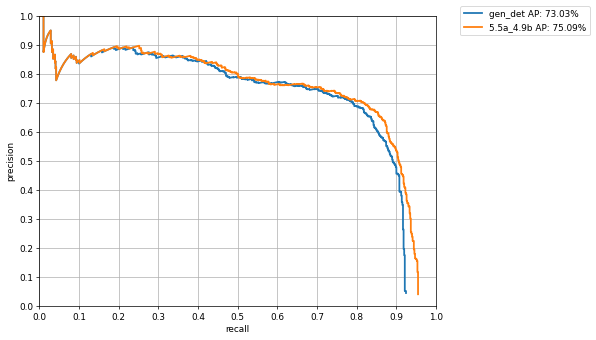

In [16]:
fig = plt.figure(figsize=(8,6), dpi=64, facecolor='w', edgecolor='k')

for i in range(len(ret)):
  # if i in (0,2,3):

    param = ret[i]['param']
    precision = ret[i]['precision']
    recall = ret[i]['recall']
    average_precision = ret[i]['AP']
    ap_str = "{0:.2f}%".format(average_precision * 100)
    plt.plot(recall, precision, linewidth=2, label='%s AP: %s' % (param,ap_str))


plt.xlim([0, 1])
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, step=0.1))

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left')
plt.grid()

In [ ]:
 # 4.2a, 4b
 # 5.5a, 4.9b
 # 6.6a, 5.8b?
 # 6.2a, 5.4b

 [4.2, 5.5, 6.2]
 [4,4.9,5.4]

In [18]:
i = 1
param = ret[i]['param']
precision = ret[i]['precision']
recall = ret[i]['recall']
average_precision = ret[i]['AP']
ap_str = "{0:.2f}%".format(average_precision * 100)

In [19]:
print(param)

5.5a_4.9b


In [22]:
with open(os.path.join(eval_dir,'sigmoid_55_a_49_b','dbinfo.plk'), 'wb') as handle:
    pickle.dump(ret[1], handle) # , protocol=pickle.HIGHEST_PROTOCOL